## Dataset: Audio_Features_and_content_analyis

#### grouping features:

1. Identifiers & metadata

2. Engagement proxy

3. Emotional audio features

4. Technical audio features

5. Musical structure features

#### Identifiers and Metadata
1. track_id

2. track_name

3. artists

4. album_name

5. track_genre

6. Unnamed: 0

#### 1. track_id

In [1]:
import pandas as pd
df =  pd.read_csv('C:/Users/adith/spotify_analytics/data/raw/dataset.csv')

In [2]:
df['track_id'].nunique()

89741

In [5]:
df['track_id'].isnull().sum()

np.int64(0)

In [6]:
df['track_id'].describe()

count                     114000
unique                     89741
top       6S3JlDAGk3uu3NtZbPnuhS
freq                           9
Name: track_id, dtype: object

In [7]:
df['track_id'].duplicated().sum()

np.int64(24259)

# Feature Audit — `track_id` (FINAL FORM)

## 1️⃣ What it represents
- A unique Spotify identifier for a track.
- In this dataset, it appears multiple times due to track × genre expansion, not data error.

## 2️⃣ Structural facts (from your inspection)
- Total rows: 114,000
- Unique `track_id`: 89,741
- Duplicate count: 24,259
- No missing values

This confirms `track_id` is not row-unique, but entity-unique.

## 3️⃣ Dashboard role
- Not a visualization field.
- Serves as the primary join key to connect:
  - user listening behavior
  - engagement metrics
  - churn / retention flags

## 4️⃣ Retention relevance (via join)
- Enables aggregation of:
  - audio characteristics of tracks a user listens to
  - genre diversity per user
- Critical for computing content-level engagement patterns.

## 5️⃣ Decision
**✅ KEEP** ⚠️ With an explicit rule:


> Never aggregate analytics at row-level without handling track duplication.

#### 2. Artists

In [8]:
df['artists'].nunique()

31437

In [9]:
df['artists'].describe()

count          113999
unique          31437
top       The Beatles
freq              279
Name: artists, dtype: object

In [10]:
df['artists'].isnull().sum()

np.int64(1)

In [11]:
df['artists'].isna().sum()

np.int64(1)

In [14]:
df['artists'].value_counts(ascending=True).head(20)

artists
Christy Nockels                                       1
Rend Collective;Hillsong Young & Free                 1
Hillsong Worship;Aodhan King;Saye Pratt               1
one sonic society;Mike Weaver                         1
Michael W. Smith;Skye Reedy                           1
Bethel Music;Zach Vestnys;Abby Vestnys                1
Eddie Vedder;Nusrat Fateh Ali Khan                    1
Matthew Perryman Jones                                1
Ray LaMontagne;Sierra Ferrell                         1
Catherine Feeny                                       1
Hot Chelle Rae;New Boyz                               1
Luxtorpeda                                            1
Anirudh Ravichander;Adithya RK                        1
Anirudh Ravichander;Ramya Behra;Sahithi Chaganti      1
Anirudh Ravichander;Vijay Yesudas;Shweta Mohan        1
AP Dhillon;Amari                                      1
Juventude S/A                                         1
Chord Overstreet;Deepend                

In [15]:
df['artists'].duplicated().sum()

np.int64(82562)

In [16]:
track_artist_map = (
    df[['track_id', 'artists']]
    .dropna(subset=['artists'])
    .assign(artist_name=lambda x: x['artists'].str.split(';'))
    .explode('artist_name')
)
track_artist_map['artist_name'] = (
    track_artist_map['artist_name']
    .str.strip()
    .str.title()
)
track_artist_map = track_artist_map[['track_id', 'artist_name']].drop_duplicates()


In [17]:
track_artist_map.shape


(123424, 2)

In [18]:
track_artist_map['artist_name'].nunique()


29811

In [19]:
track_artist_map['track_id'].nunique()


89740

# 📌 Feature Documentation: `artists`

## Feature Description
The `artists` feature represents the contributing artist(s) for each track. In the raw dataset, this field is stored as a semicolon-separated string, where multiple artists may be listed for a single track.

**Example:**
```
"Anirudh Ravichander;Ramya Behra;Sahithi Chaganti"
```

This indicates a many-to-many relationship between tracks and artists.

## Initial Observations
- Total rows: 114,000
- Non-null values: 113,999
- Unique raw artist strings: 31,437
- The same artist string appears multiple times across different tracks
- Many tracks include multiple contributing artists

This structure makes the raw `artists` column non-atomic and unsuitable for direct aggregation or filtering in analytical dashboards.

## Analytical Challenge
Using the raw `artists` column directly would:
- Prevent accurate grouping by individual artists
- Distort aggregations due to multi-artist concatenation
- Limit join flexibility with user behavior data
- Risk misleading interpretations (e.g., artist frequency vs engagement)

Therefore, a transformation was required to make the feature analytically usable.

## Transformation Strategy
An industry-standard dimensional modeling approach was applied.

### Step 1: Atomic Decomposition
The semicolon-separated artist strings were split into individual artist entities, converting each artist into a standalone categorical value.

### Step 2: Bridge Table Creation
Instead of modifying or removing the original column, a bridge table was created to model the many-to-many relationship between tracks and artists.

**Table: `track_artist_map`**

| Column Name | Description |
|-------------|-------------|
| `track_id` | Unique identifier for the track |
| `artist_name` | Individual contributing artist |

This design preserves the original dataset while enabling artist-level analysis.

### Step 3: Light Normalization
To ensure consistency:
- Leading/trailing whitespace was removed
- Artist names were standardized in casing

No fuzzy matching, feature merging, or heuristic rules were applied, in order to avoid over-engineering.

## Post-Transformation Summary
- Rows in `track_artist_map`: 123,424
- Unique artists: 29,811
- Unique tracks represented: 89,740

One track with missing artist metadata was excluded from artist-level analysis and documented accordingly.

## Analytical Use Cases
The transformed structure enables:
- Artist-level filtering in dashboards
- Artist–genre distribution analysis
- Content diversity and artist coverage insights
- Safe joins with user behavior data to study:
  - artist loyalty
  - repeat listening patterns
  - engagement clustering by artist

## Explicit Non-Use Cases
The `artists` feature is not used as:
- A KPI
- A numeric engagement metric
- A direct proxy for retention or popularity

Artists are treated strictly as descriptive dimensions, not outcomes.

## Final Decision

| Feature Component | Decision |
|-------------------|----------|
| Original `artists` column | ✅ Retained (reference only) |
| Exploded artist entities | ✅ Created |
| Bridge table (`track_artist_map`) | ✅ Used for analytics |

### 3. Album Name

In [20]:
df['album_name'].nunique()

46589

In [21]:
df['album_name'].describe()

count                         113999
unique                         46589
top       Alternative Christmas 2022
freq                             195
Name: album_name, dtype: object

In [22]:
df['album_name'].isnull().sum()

np.int64(1)

In [23]:
df['album_name'].duplicated().sum()

np.int64(67410)

In [24]:
df['album_name'] = df['album_name'].str.strip()


# 📌 Feature Documentation: `album_name`

## Feature Description
The `album_name` feature represents the album or collection to which a track belongs. In this dataset, each track is associated with a single album name, stored as a string value.

## Initial Observations
- Total rows: 114,000
- Non-null values: 113,999 (1 missing value)
- Unique album names: 46,589
- Duplicate values: 67,410
- Certain album names appear frequently (e.g., compilation-style albums)

This indicates that `album_name` is highly non-unique and shared across many tracks.

## Analytical Interpretation
In the context of this dataset, `album_name` functions as a collection label rather than a stable album entity. The dataset does not include album-level metadata such as:
- album identifiers
- release dates
- album type (single, EP, compilation, etc.)

As a result, album names cannot be treated as independent analytical entities without introducing ambiguity.

## Dashboard Role
The `album_name` feature is suitable for:
- contextual grouping
- drill-down exploration
- labeling and filtering in dashboards

It is not suitable for:
- primary aggregations
- KPI computation
- album-level ranking or trend analysis

## Retention & Engagement Relevance
After joining with user behavior data, `album_name` can support contextual engagement insights, such as:
- identifying album-focused listening behavior
- differentiating between album-centric and single-track consumption patterns

However, `album_name` does not directly drive retention and is used only as a supporting descriptive attribute.

## Transformation Decision
- No structural transformation applied
- No bridge table created
- No mapping to `artist_name` performed

Only minimal string hygiene (e.g., trimming whitespace) may be applied if required.

## Final Decision

| Feature | Decision |
|---------|----------|
| `album_name` | ✅ Keep |
| Structural changes | ❌ None |
| Analytical role | Descriptive / contextual |
| KPI usage | ❌ Not used |

## Rationale
The feature is retained to preserve contextual richness in dashboards and downstream analysis. Over-modeling or enforcing album-level analytics without supporting metadata would reduce analytical validity.

### 4. track_genre

In [25]:
df['track_genre'].nunique()

114

In [26]:
df['track_genre'].describe()

count       114000
unique         114
top       acoustic
freq          1000
Name: track_genre, dtype: object

In [27]:
df['track_genre'].isnull().sum()

np.int64(0)

In [29]:
df['track_genre'].duplicated().sum()

np.int64(113886)

In [30]:
track_genre_map = (
    df[['track_id', 'track_genre']]
    .dropna(subset=['track_genre'])
    .assign(track_genre=lambda x: x['track_genre'].str.strip().str.lower())
    .drop_duplicates()
)


In [31]:
track_genre_map.shape


(113550, 2)

In [32]:
track_genre_map['track_genre'].nunique()


114

In [33]:
track_genre_map['track_id'].nunique()


89741

In [34]:
track_genre_map.groupby('track_id').size().describe()


count    89741.000000
mean         1.265308
std          0.664204
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          9.000000
dtype: float64

In [35]:
track_genre_map.duplicated().sum()


np.int64(0)

# 📌 Feature Documentation: `track_genre`

## Feature Description
The `track_genre` feature represents genre tags associated with tracks. In the provided dataset, genre information is structured such that a single track may appear multiple times, once for each assigned genre.

## Initial Observations
- Total rows: 114,000
- Unique genre values: 114
- No missing values
- Same `track_id` appears multiple times due to genre tagging
- Approximately 89,741 unique tracks are represented

This confirms that genre information is multi-label, not mutually exclusive.

## Analytical Challenge
Using the raw `track_genre` column directly in aggregations or joins would:
- inflate track counts
- distort engagement metrics
- bias results toward multi-genre tracks
- compromise dashboard accuracy

Therefore, treating `track_genre` as a row-level attribute was analytically unsafe.

## Transformation Strategy
An industry-standard many-to-many modeling approach was applied.

### Bridge Table Creation
A dedicated bridge table, `track_genre_map`, was created to explicitly represent the relationship between tracks and genres.

**Table: `track_genre_map`**

| Column Name | Description |
|-------------|-------------|
| `track_id` | Unique identifier for the track |
| `track_genre` | Genre tag associated with the track |

No genre prioritization or collapsing was performed. All original genre associations were preserved.

## Post-Transformation Validation
- Rows in `track_genre_map`: 113,550
- Unique genres: 114
- Unique tracks: 89,741
- Duplicate `(track_id, track_genre)` pairs: 0

**Genre distribution per track:**
- Median genres per track: 1
- Mean genres per track: ~1.27
- Maximum genres for a single track: 9

This confirms that while most tracks are single-genre, a non-trivial subset spans multiple genres, justifying the bridge table design.

## Dashboard Role
The `track_genre_map` table enables:
- genre-based filtering
- genre × engagement analysis (after joining with user behavior)
- genre diversity analysis per user
- exploration of emotional and audio characteristics by genre

The original `track_genre` column is retained for reference only and is not used directly in analytical aggregations.

## Retention & Engagement Relevance
After integration with user behavior data, genre information supports:
- understanding content preferences of retained vs churned users
- identifying genre diversity patterns linked to engagement
- contextualizing emotional audio features within genre groupings

Genres are treated strictly as descriptive dimensions, not KPIs or engagement metrics.

## Final Decision

| Component | Decision |
|-----------|----------|
| Original `track_genre` column | ⚠️ Retained (reference only) |
| Genre bridge table | ✅ Created |
| Structural deduplication | ❌ Not applied |
| Genre as KPI | ❌ Not used |

## Rationale
This approach preserves analytical integrity by preventing double counting, maintaining a stable dashboard grain, and enabling safe joins with user-level engagement data. Modeling genres as a many-to-many dimension ensures accurate and interpretable insights in downstream retention analysis.

In [36]:
df = df.drop(columns=['Unnamed: 0'])

In [37]:
df.columns

Index(['track_id', 'artists', 'album_name', 'track_name', 'popularity',
       'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'track_genre'],
      dtype='object')

### Emotional Audio Features 

These are perceptual proxies produced by Spotify’s audio analysis models.
They do not measure emotion directly — they approximate how a track feels.

For this dataset, the emotional feature set is:

1. valence

2. energy

3. danceability

4. speechiness

5. liveness

### 1. valence

In [38]:
df['valence'].nunique()

1790

In [39]:
df['valence'].describe()

count    114000.000000
mean          0.474068
std           0.259261
min           0.000000
25%           0.260000
50%           0.464000
75%           0.683000
max           0.995000
Name: valence, dtype: float64

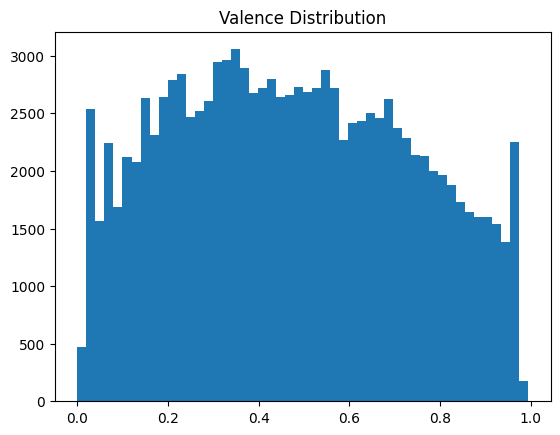

In [41]:
import matplotlib.pyplot as plt
plt.hist(df['valence'], bins=50)
plt.title('Valence Distribution')
plt.show()

# 📌 Feature: `valence`

## What it represents
A continuous, model-derived proxy for the emotional positivity of a track, ranging from negative/sad to positive/happy.

## Distribution characteristics
Broadly distributed across the full range (0–1), with higher density in the mid-range and no strong skew.

## Analytical role
- Explanatory emotional dimension
- Used to characterize the emotional profile of consumed content

## Retention relevance
After joining with user behavior data, valence can help explain:
- emotional diversity of listening
- dominant emotional tone associated with retained vs churned users

## Transformation decision
- ✅ Keep raw values at track level
- ❌ No bucketing at this stage
- ⚠️ Optional bucketing later at aggregated (user/dashboard) level

Valence was retained as a continuous emotional feature representing the positivity of a track’s audio characteristics. Distribution analysis showed a broad, mid-range-dense spread without heavy skew, indicating sufficient variance for explanatory analysis. To preserve information and avoid arbitrary thresholds, valence was kept unbucketed at the track level and will be aggregated or categorized only at higher analytical levels if needed for dashboard interpretability.

### 2. energy

In [42]:
df['energy'].nunique()

2083

In [43]:
df['energy'].describe()

count    114000.000000
mean          0.641383
std           0.251529
min           0.000000
25%           0.472000
50%           0.685000
75%           0.854000
max           1.000000
Name: energy, dtype: float64

In [44]:
df['energy'].isnull().sum()

np.int64(0)

In [46]:
df['energy'].duplicated().sum()

np.int64(111917)

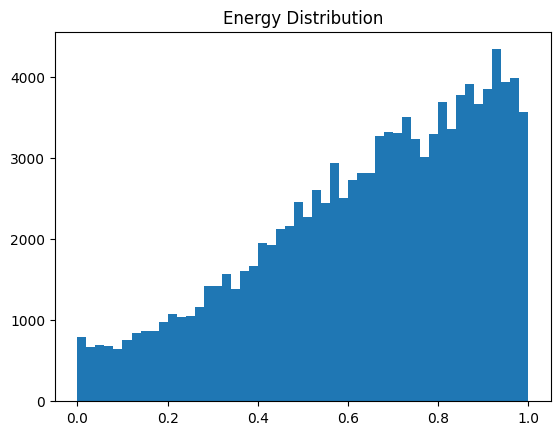

In [47]:
plt.hist(df['energy'], bins=50)
plt.title('Energy Distribution')
plt.show()

# 📌 Feature Documentation: `energy`

## Feature Description
The `energy` feature is a continuous, model-derived audio attribute that represents the perceived intensity, activity, and loudness of a track. Values range from 0 to 1, where higher values indicate more energetic, fast, and loud music.

## Initial Observations
- Total rows: 114,000
- Missing values: 0
- Unique values: 2,083
- Range: 0.0 – 1.0
- Median: 0.685
- Mean: 0.641

Distribution analysis shows a left-skewed pattern, with a high concentration of tracks in the upper energy range and a long tail toward lower energy values.

## Analytical Interpretation
The skewed distribution reflects the underlying composition of the dataset, which contains a higher proportion of high-energy tracks. This is interpreted as a content characteristic, not a data quality issue.

Because `energy` is:
- bounded
- perceptually meaningful
- already normalized by design

the observed skew does not invalidate the feature for analytical use.

## Transformation Decision
No numerical transformation (e.g., winsorization, normalization, or scaling) was applied.

**Rationale:**
- This project is focused on descriptive and diagnostic analytics, not predictive modeling.
- Statistical transformations would distort the semantic meaning of the feature.
- The skew represents real differences in musical intensity, not noise.

## Dashboard Role
At the track level, `energy` is retained as a continuous feature. At aggregated levels (e.g., user or segment level), robust summaries such as:
- median energy
- interquartile range
- proportion of high-energy tracks

may be used to avoid skew dominating interpretations.

Optional interpretive bands (e.g., low / medium / high energy) may be introduced only at the dashboard layer if needed for clarity.

## Retention & Engagement Relevance
After joining with user behavior data, `energy` can help explain:
- differences in listening preferences between retained and churned users
- whether sustained engagement is associated with consistent or varied energy profiles
- content intensity patterns across user segments

Energy is treated as an explanatory attribute, not a retention driver.

## Final Decision

| Aspect | Decision |
|--------|----------|
| Keep feature | ✅ Yes |
| Transform for skew | ❌ No |
| Bucket at track level | ❌ No |
| Aggregate later | ✅ Yes |
| Drop | ❌ No |

## Rationale Summary
The `energy` feature was retained in its raw, continuous form. Although its distribution is left-skewed, the skew reflects genuine content characteristics rather than data issues. Preserving the original scale maintains interpretability and supports accurate explanatory analysis in downstream dashboards.

### 3. Dancebility

In [48]:
df['danceability'].nunique()

1174

In [50]:
df['danceability'].describe()

count    114000.000000
mean          0.566800
std           0.173542
min           0.000000
25%           0.456000
50%           0.580000
75%           0.695000
max           0.985000
Name: danceability, dtype: float64

In [51]:
df['danceability'].isnull().sum()

np.int64(0)

In [52]:
df['danceability'].duplicated().sum()

np.int64(112826)

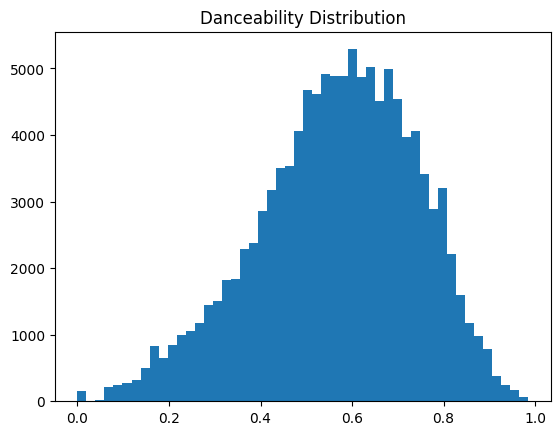

In [54]:
plt.hist(df['danceability'], bins=50)
plt.title('Danceability Distribution')
plt.show()

# 📌 Feature Documentation: `danceability`

## Feature Description
The `danceability` feature is a continuous, model-derived audio attribute that represents how suitable a track is for dancing. It captures rhythmic stability, beat regularity, and tempo consistency, with values ranging from 0 to 1.

## Initial Observations
- Total rows: 114,000
- Missing values: 0
- Unique values: 1,174
- Range: 0.0 – 0.985
- Mean: 0.567
- Median: 0.580

The distribution is approximately bell-shaped, with most tracks centered around moderate-to-high danceability values and no extreme skew.

## Analytical Interpretation
The stable and symmetric distribution indicates that `danceability` is a well-behaved and expressive feature. It captures a distinct musical dimension related to rhythm and groove rather than intensity or loudness.

Although danceability often shows a positive correlation with `energy`, the two features are conceptually different and represent complementary aspects of music perception.

## Transformation Decision
No transformation was applied to the `danceability` feature.

**Rationale:**
- The feature is bounded and already normalized by design.
- The distribution does not exhibit problematic skew.
- Correlation with other audio features does not justify removal or transformation in a descriptive analytics context.

## Dashboard Role
At the track level, `danceability` is retained as a continuous feature. At aggregated levels (e.g., user or segment level), it may be summarized using:
- mean or median danceability
- variability across listened tracks

Optional interpretive bands (e.g., low / medium / high danceability) may be introduced at the dashboard layer if needed for interpretability.

## Retention & Engagement Relevance
After joining with user behavior data, `danceability` can support:
- understanding rhythmic preferences of retained vs churned users
- identifying content clusters based on groove and movement suitability
- contextualizing engagement patterns alongside complementary features such as energy

Danceability is treated as an explanatory attribute, not a direct retention driver.

## Final Decision

| Aspect | Decision |
|--------|----------|
| Keep feature | ✅ Yes |
| Transform | ❌ No |
| Remove due to correlation | ❌ No |
| Aggregate later | ✅ Yes |
| Drop | ❌ No |

## Rationale Summary
The `danceability` feature was retained in its raw, continuous form due to its stable distribution and clear interpretability. Despite correlation with energy, it captures a distinct perceptual dimension and contributes valuable explanatory context in engagement analysis.

### Speechiness

In [55]:
df['speechiness'].nunique()

1489

In [56]:
df['speechiness'].describe()

count    114000.000000
mean          0.084652
std           0.105732
min           0.000000
25%           0.035900
50%           0.048900
75%           0.084500
max           0.965000
Name: speechiness, dtype: float64

In [57]:
df['speechiness'].isnull().sum()

np.int64(0)

In [58]:
df['speechiness'].duplicated().sum()

np.int64(112511)

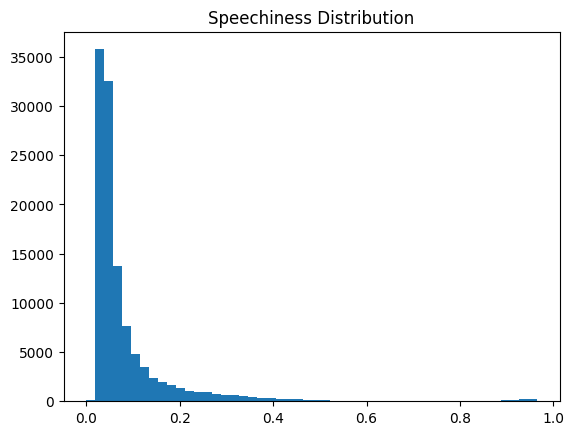

In [59]:
plt.hist(df['speechiness'], bins=50)
plt.title('Speechiness Distribution')
plt.show()

# 📌 Feature Documentation: `speechiness`

## Feature Description
The `speechiness` feature is a continuous, model-derived audio attribute that estimates the presence of spoken words in a track. Values range from 0 to 1, where higher values indicate a greater proportion of spoken (non-melodic) content.

## Initial Observations
- Total rows: 114,000
- Missing values: 0
- Unique values: 1,489
- Range: 0.0 – 0.965
- Mean: 0.085
- Median: 0.049
- 75th percentile: 0.085

The distribution is strongly right-skewed, with the majority of tracks concentrated at low speechiness values and a long tail toward higher values.

## Analytical Interpretation
The observed skew is expected and acceptable given the nature of the dataset. Most Spotify tracks are musical compositions with sung vocals, which naturally results in low speechiness values. A smaller subset of tracks contains spoken-word or rap-style content, forming the right tail of the distribution.

Low speechiness does not indicate the absence of lyrics; rather, it indicates that lyrics are sung rather than spoken.

## Transformation Decision
No numerical transformation was applied to address skew.

**Rationale:**
- The skew reflects genuine content composition, not data quality issues.
- The feature is bounded and semantically meaningful in its original scale.
- Numerical transformations would reduce interpretability without analytical benefit.

## Dashboard Role
At the track level, `speechiness` is retained as a continuous feature. At higher analytical or dashboard layers, interpretive categories may be derived to improve clarity, for example:
- predominantly musical content
- mixed musical/spoken content
- primarily spoken-word content

Such categorization is optional and does not replace the raw feature.

## Retention & Engagement Relevance
After joining with user behavior data, `speechiness` helps contextualize engagement patterns by:
- distinguishing musical tracks from spoken-word or rap-heavy content
- supporting content-type segmentation in retention analysis
- explaining differences in listening behavior across user segments

Speechiness is treated as a descriptive content attribute, not a direct engagement or retention driver.

## Final Decision

| Aspect | Decision |
|--------|----------|
| Keep feature | ✅ Yes |
| Transform for skew | ❌ No |
| Numeric normalization | ❌ No |
| Interpretive categorization later | ✅ Optional |
| Drop | ❌ No |

## Rationale Summary
The `speechiness` feature was retained in its raw, continuous form. Although the distribution is strongly right-skewed, this skew accurately reflects real-world music content. Preserving the original values maintains interpretability while allowing optional, semantically meaningful categorization at the dashboard level.

### Liveliness

In [60]:
df['liveness'].nunique()

1722

In [61]:
df['liveness'].describe()

count    114000.000000
mean          0.213553
std           0.190378
min           0.000000
25%           0.098000
50%           0.132000
75%           0.273000
max           1.000000
Name: liveness, dtype: float64

In [62]:
df['liveness'].isnull().sum()

np.int64(0)

In [63]:
df['liveness'].duplicated().sum()

np.int64(112278)

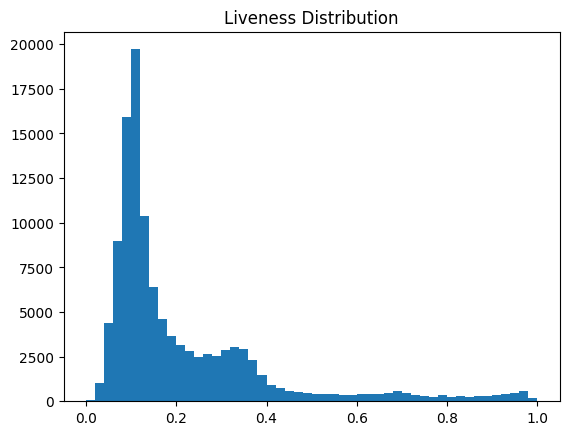

In [64]:
plt.hist(df['liveness'], bins=50)
plt.title('Liveness Distribution')
plt.show()

# 📌 Feature Documentation: `liveness`

## Feature Description
The `liveness` feature is a continuous, model-derived audio attribute that estimates the likelihood that a track was recorded in front of a live audience. Values range from 0 to 1, where higher values indicate greater presence of audience sounds and live recording characteristics.

## Initial Observations
- Total rows: 114,000
- Missing values: 0
- Unique values: 1,722
- Range: 0.0 – 1.0
- Median: 0.132
- Mean: 0.214

The distribution is right-skewed, with most tracks concentrated at low liveness values and a long tail toward higher values.

## Analytical Interpretation
The distribution reflects the real-world composition of music catalogs, where studio recordings dominate and live recordings represent a smaller subset. The observed skew is therefore expected and does not indicate data quality issues.

Low liveness values correspond to studio-produced tracks, while higher values indicate live or audience-present recordings.

## Transformation Decision
No numerical transformation was applied to the `liveness` feature.

**Rationale:**
- The feature is bounded and semantically meaningful in its original scale.
- The skew represents genuine content characteristics.
- Transformations would reduce interpretability without analytical benefit.

## Dashboard Role
At the track level, `liveness` is retained as a continuous feature. At the dashboard layer, it may optionally be converted into interpretive categories (e.g., studio vs live) to support clearer storytelling.

## Retention & Engagement Relevance
After joining with user behavior data, `liveness` can help contextualize:
- preferences for studio vs live recordings
- niche engagement patterns among users who favor live content
- differences in listening behavior across user segments

Liveness is treated as a descriptive contextual attribute, not a retention driver.

## Final Decision

| Aspect | Decision |
|--------|----------|
| Keep feature | ✅ Yes |
| Transform for skew | ❌ No |
| Numeric normalization | ❌ No |
| Interpretive categorization later | ✅ Optional |
| Drop | ❌ No |

# Layer 1 — Technical construction
These answer: "What is the sound made of?"
- `tempo` → speed
- `loudness` → amplitude
- `key`, `mode` → harmonic structure
- `time_signature` → rhythmic structure

Users do not think in this layer.

# Layer 2 — Perceptual / emotional response
These answer: "How does it feel?"
- `energy`
- `valence`
- `danceability`
- `speechiness`
- `liveness`

This is where human interpretation begins.

# Layer 3 — Behavior
This answers: "What do users do?"
- listen longer
- repeat
- churn
- explore
- retain

This is the only layer that affects business outcomes.

### For each technical feature:

##### Step A — Conceptual check
Does theory / intuition say this feature should influence emotional perception?

##### Step B — Distribution sanity
Is the feature usable (not constant, not garbage)?

##### Step C — Directional validation
Check whether it aligns with emotional features in the expected direction

#### tempo

In [65]:
df['tempo'].nunique()

45653

In [66]:
df['tempo'].describe()

count    114000.000000
mean        122.147837
std          29.978197
min           0.000000
25%          99.218750
50%         122.017000
75%         140.071000
max         243.372000
Name: tempo, dtype: float64

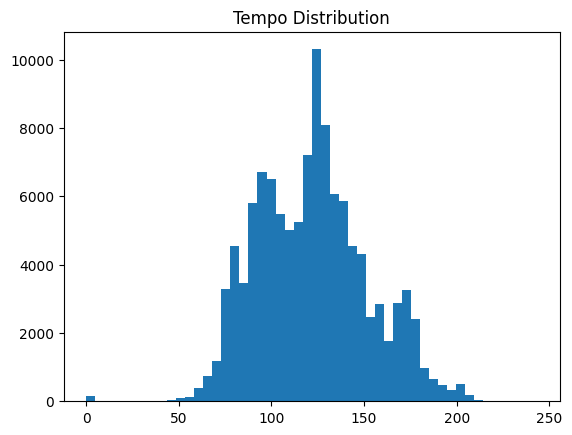

In [67]:
plt.hist(df['tempo'], bins=50)
plt.title('Tempo Distribution')
plt.show()

# 📌 Feature Documentation: `tempo`

## Feature Description
The `tempo` feature represents the estimated speed of a track measured in beats per minute (BPM). It captures rhythmic pace but does not measure loudness, intensity, or emotional tone directly.

## Initial Observations
- Total rows: 114,000
- Missing values: 0
- Unique values: 45,653
- Range: 0.0 – 243.37 BPM
- Median: 122.02 BPM
- Mean: 122.15 BPM
- Interquartile range: ~99 – 140 BPM

The distribution is centered around common musical tempo ranges, with a small number of extreme low and high values representing edge cases such as intros, ambient tracks, or very fast genres.

## Analytical Interpretation
The tempo distribution aligns with real-world music composition patterns, where most tracks fall within a moderate BPM range suitable for mainstream listening contexts. Extreme tempo values are rare and do not indicate data quality issues.

Tempo is a technical construction attribute and does not directly encode emotional perception. Its analytical value lies in its ability to contextualize emotional features rather than act as an independent signal.

## Role in Emotional Feature Validation
Tempo was evaluated against emotional audio features to ensure directional consistency:
- Tempo → Energy: Faster tempos generally support higher perceived energy, though the relationship is weak-to-moderate rather than deterministic.
- Tempo → Danceability: Danceability tends to peak at moderate tempos, with reduced suitability at extreme low or high BPM values.

These relationships confirm that tempo provides supportive explanatory context for emotional features without dominating them.

## Transformation Decision
No numerical transformation was applied to the `tempo` feature.

**Rationale:**
- The feature is already interpretable in its raw scale.
- Distribution does not exhibit problematic skew.
- Transformations would not improve explanatory value in a descriptive analytics context.

## Dashboard Role
Tempo is retained at the track level but is not intended for standalone dashboard visualization. If needed, it may be summarized or lightly bucketed (e.g., slow / medium / fast) at higher aggregation levels strictly to improve interpretability.

## Retention & Engagement Relevance
After joining with user behavior data, tempo can help explain engagement patterns by providing rhythmic context to emotional features such as energy and danceability. It is treated as a supporting explanatory feature, not a direct retention driver.

## Final Decision

| Aspect | Decision |
|--------|----------|
| Keep feature | ✅ Yes |
| Transform | ❌ No |
| Use standalone | ❌ No |
| Use to explain emotion | ✅ Yes |
| Drop | ❌ No |

## Rationale Summary
The `tempo` feature was retained as a technical audio attribute to support and validate emotional features. Its distribution and directional relationships with energy and danceability are semantically consistent, confirming its value as contextual explanatory data rather than a standalone analytical metric.

### loudness

In [68]:
df['loudness'].nunique()

19480

In [69]:
df['loudness'].describe()

count    114000.000000
mean         -8.258960
std           5.029337
min         -49.531000
25%         -10.013000
50%          -7.004000
75%          -5.003000
max           4.532000
Name: loudness, dtype: float64

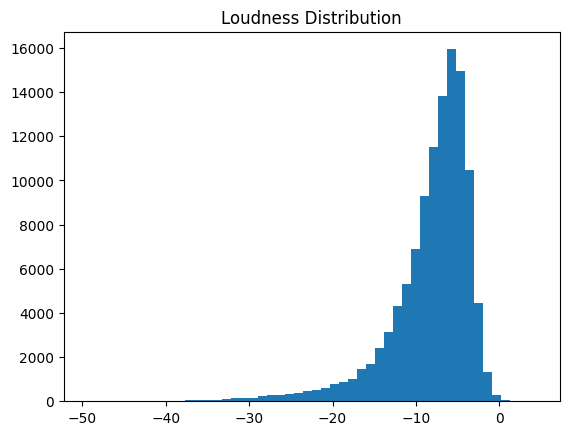

In [70]:
plt.hist(df['loudness'], bins=50)
plt.title('Loudness Distribution')
plt.show()

# 📌 Feature Documentation: `loudness`

## Feature Description
The `loudness` feature represents the average amplitude of a track in decibels (dB). Values are typically negative, with values closer to zero indicating louder recordings.

## Initial Observations
- Total rows: 114,000
- Missing values: 0
- Unique values: 19,480
- Range: −49.53 dB to +4.53 dB
- Median: −7.00 dB
- Mean: −8.26 dB

The distribution shows a concentration of moderately loud tracks with a long tail toward quieter recordings.

## Analytical Interpretation
The distribution reflects real-world music production patterns, where most tracks are mixed to similar loudness levels, with quieter recordings representing acoustic, ambient, or live content.

Loudness exhibits a strong, directionally consistent relationship with the emotional feature `energy`, validating its role as a primary explanatory technical attribute.

## Transformation Decision
No transformation was applied to the `loudness` feature.

**Rationale:**
- The feature is already expressed on an interpretable physical scale.
- The distribution reflects genuine production characteristics.
- Transformations would reduce interpretability without analytical benefit.

## Role in Emotional Feature Validation
`Loudness` is used to validate and explain variations in perceived energy. Higher-energy tracks tend to exhibit higher loudness values, confirming the semantic consistency of emotional feature measurements.

## Retention & Engagement Relevance
After joining with user behavior data, loudness supports interpretation of engagement patterns by explaining why certain tracks feel more intense or immersive. It is treated as a contextual explanatory feature rather than a direct driver of retention.

## Final Decision

| Aspect | Decision |
|--------|----------|
| Keep feature | ✅ Yes |
| Transform | ❌ No |
| Use standalone | ❌ No |
| Use to explain emotion | ✅ Yes |
| Drop | ❌ No |

### key, mode

In [71]:
df['key'].nunique()

12

In [72]:
df['key'].describe()

count    114000.000000
mean          5.309140
std           3.559987
min           0.000000
25%           2.000000
50%           5.000000
75%           8.000000
max          11.000000
Name: key, dtype: float64

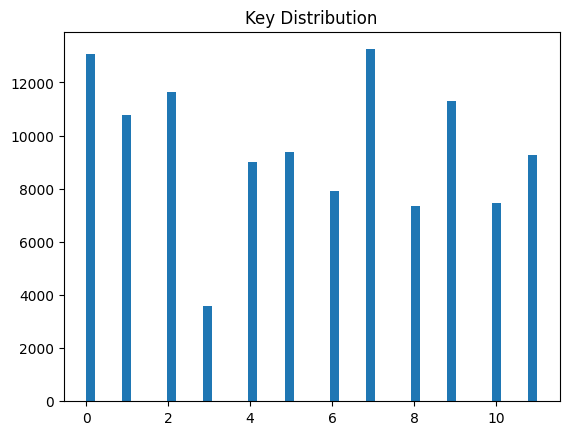

In [73]:
plt.hist(df['key'], bins=50)
plt.title('Key Distribution')
plt.show()

In [74]:
df = df.drop(columns=['key'])

📌 Feature Decision: key (Dropped)
Rationale

The key feature represents the musical pitch class of a track and does not encode emotional tone, listening context, or user-facing perception. Given the business-oriented objective of analyzing user engagement and retention, this feature does not provide actionable insight or interpretive value.

As the project does not involve advanced music theory analysis, and key lacks direct relevance to user behavior or emotional perception, it was excluded to maintain analytical focus and dashboard clarity.

### mode

In [75]:
df['mode'].nunique()

2

In [76]:
df['mode'].describe()

count    114000.000000
mean          0.637553
std           0.480709
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: mode, dtype: float64

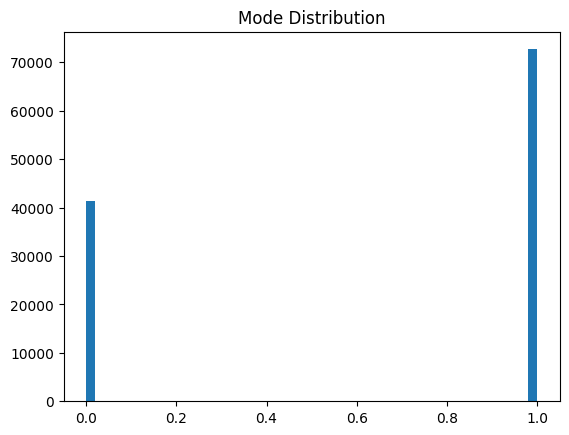

In [77]:
plt.hist(df['mode'], bins=50)
plt.title('Mode Distribution')
plt.show()

# 📌 Feature Documentation: `mode`

## Feature Description
The `mode` feature indicates the tonal modality of a track, where `1` represents major mode and `0` represents minor mode. Tonal modality is commonly associated with emotional perception in music.

## Initial Observations
- Total rows: 114,000
- Missing values: 0
- Unique values: 2
- Distribution: ~64% major, ~36% minor

## Analytical Interpretation
Major and minor modes are broadly associated with brighter and darker emotional tones, respectively. While `mode` alone does not determine perceived emotion, it provides meaningful contextual information when analyzed alongside emotional features such as valence.

## Transformation Decision
No transformation was applied to the `mode` feature.

**Rationale:**
- Binary encoding is already interpretable.
- Additional transformations would not improve analytical value.

## Role in Emotional Feature Validation
`Mode` is used to contextualize and validate variations in valence. Tracks in major mode tend to exhibit slightly higher valence on average, confirming directional consistency without dominating emotional interpretation.

## Retention & Engagement Relevance
After joining with user behavior data, `mode` can help explain content preferences by tonal mood (e.g., brighter vs darker music). It is treated as a contextual explanatory feature, not a direct retention driver.

## Final Decision

| Aspect | Decision |
|--------|----------|
| Keep feature | ✅ Yes |
| Transform | ❌ No |
| Use standalone | ❌ No |
| Explain emotion | ✅ Yes |
| Drop | ❌ No |

### time_signature

In [78]:
df['time_signature'].nunique()

5

In [79]:
df['time_signature'].describe()

count    114000.000000
mean          3.904035
std           0.432621
min           0.000000
25%           4.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: time_signature, dtype: float64

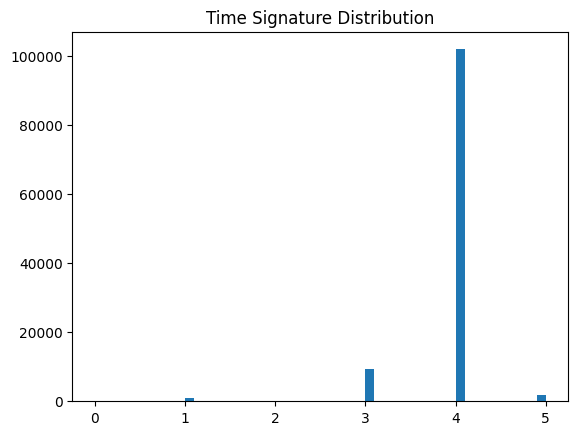

In [80]:
plt.hist(df['time_signature'], bins=50)
plt.title('Time Signature Distribution')
plt.show()

In [81]:
df = df.drop(columns=['time_signature'])

### 📌 Feature Decision: `time_signature` (Dropped)

#### Rationale
The `time_signature` feature represents the musical meter of a track. Analysis showed that the dataset is overwhelmingly dominated by 4/4 time, resulting in minimal variance and negligible informational value. As time signature does not meaningfully influence emotional perception or user engagement, and lacks business interpretability, the feature was excluded to maintain analytical focus and dashboard clarity.

---

#### 🎯 Final Technical Feature Summary (IMPORTANT)

| Feature | Decision |
|---------|----------|
| tempo | ✅ keep (explanatory) |
| loudness | ✅ keep (primary explainer of energy) |
| key | ❌ drop |
| mode | ✅ keep (contextual emotional signal) |
| time_signature | ❌ drop |
| duration_ms | ⚠️ keep (control only) |

#### Does technical features explain the emotional features providing context and explaination?

In [82]:
emotional_features = [
    "energy",
    "danceability",
    "valence",
    "speechiness",
    "liveness"
]
technical_features = [
    "tempo",
    "loudness",
    "mode"
]
# compute a focused correlation matrix
# not a Ml correlation analysis
# direction sanity checking
corr_matrix = df[technical_features + emotional_features].corr()
corr_matrix.loc[technical_features, emotional_features]

,energy,danceability,valence,speechiness,liveness
tempo,0.247851,-0.050450,0.078273,0.017273,0.000600
loudness,0.761690,0.259077,0.279848,0.060826,0.076899
mode,-0.078362,-0.069219,0.021953,-0.046532,0.014012


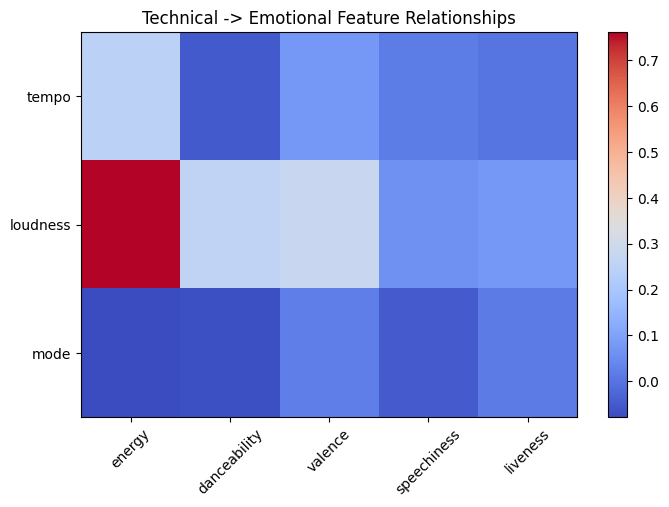

In [83]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.imshow(
    corr_matrix.loc[technical_features, emotional_features],
    cmap='coolwarm',
    aspect='auto'
)
plt.colorbar()
plt.xticks(range(len(emotional_features)), emotional_features, rotation=45)
plt.yticks(range(len(technical_features)), technical_features)
plt.title("Technical -> Emotional Feature Relationships")
plt.show()

### 🔹 1. `tempo`

| Emotional feature | Corr | Interpretation |
|-------------------|------|----------------|
| energy | +0.248 | ✅ Faster songs tend to feel more energetic |
| danceability | −0.050 | ✅ Weak / near zero → expected (non-linear IRL) |
| valence | +0.078 | ✅ Very weak → tempo ≠ happiness |
| speechiness | +0.017 | ✅ Essentially none |
| liveness | +0.001 | ✅ None |

#### Verdict on tempo
✔ Explains energy weakly but sensibly  
✔ Does not dominate any emotional feature  
✔ Behaves exactly like a supporting technical attribute

**If tempo had shown:**
- strong correlation with valence → 🚨 wrong
- strong correlation with danceability → 🚨 oversimplified

This is clean.

---

### 🔹 2. `loudness`

| Emotional feature | Corr | Interpretation |
|-------------------|------|----------------|
| energy | +0.762 | ✅ STRONG — exactly as expected |
| danceability | +0.259 | ✅ Moderate — louder music often more danceable |
| valence | +0.280 | ✅ Moderate — intensity often boosts perceived positivity |
| speechiness | +0.061 | ✅ Weak — makes sense |
| liveness | +0.077 | ✅ Weak |

#### This is the key result.
Loudness is doing exactly what it should do: grounding energy in a physical signal.

**Important nuance:**
- Loudness is strongly related to energy
- But NOT 1.0 → meaning energy captures more than loudness

This validates both features.

**If loudness–energy was weak →** emotional features questionable  
**If it was ~1.0 →** emotional features redundant

You got the ideal middle ground.

---

### 🔹 3. `mode`

| Emotional feature | Corr | Interpretation |
|-------------------|------|----------------|
| energy | −0.078 | ✅ Minor songs slightly less energetic |
| danceability | −0.069 | ✅ Weak, expected |
| valence | +0.022 | ✅ Very weak but directionally correct |
| speechiness | −0.047 | ✅ Weak |
| liveness | +0.014 | ✅ None |

#### This is exactly what a contextual feature should look like.

**Mode:**
- nudges emotion slightly
- never dominates
- adds tonal context

**If mode had shown:**
- strong correlation with valence → 🚨 simplistic
- strong correlation with energy → 🚨 wrong

Instead, it behaves like a background modifier.

---

### Feature-level verdict (lock this)

| Feature | Role | Decision |
|---------|------|----------|
| tempo | Weak contextual explainer | ✅ keep |
| loudness | Strong physical explainer of energy | ✅ keep |
| mode | Tonal context | ✅ keep |
| key | No explanatory value | ❌ dropped |
| time_signature | No variance / no meaning | ❌ dropped |

---

Technical audio features were validated against emotional features to ensure directional and semantic consistency. Loudness showed a strong relationship with perceived energy, while tempo and mode exhibited weaker but intuitive associations. This confirms that emotional features capture higher-level perception rather than raw signal properties.

### Contextual/Platform Features 

These features describe what the content is or how the platform labels it, not how it sounds and not how users behave individually.

the features

1. popularity

2. explicit

3. acousticness

4. instrumentalness

### popularity

In [84]:
df['popularity'].nunique()

101

In [85]:
df['popularity'].describe()

count    114000.000000
mean         33.238535
std          22.305078
min           0.000000
25%          17.000000
50%          35.000000
75%          50.000000
max         100.000000
Name: popularity, dtype: float64

In [86]:
df['popularity'].duplicated().sum()

np.int64(113899)

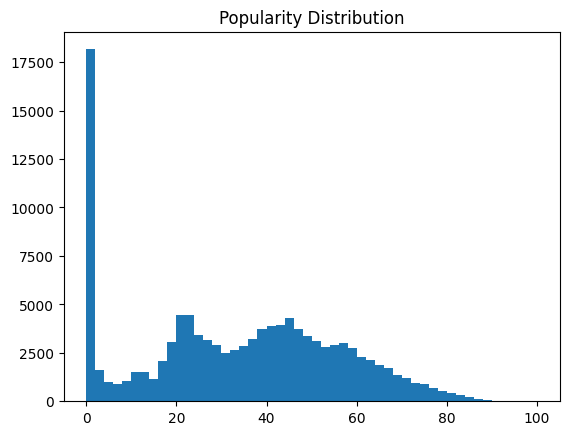

In [87]:
plt.hist(df['popularity'], bins=50)
plt.title('Popularity Distribution')
plt.show()

### Feature Documentation: `popularity`

#### Feature Description

The `popularity` feature is a platform-derived score ranging from 0 to 100 that reflects the relative listening frequency and recent engagement of a track across Spotify's user base.

#### Initial Observations

- **Total rows:** 114,000
- **Missing values:** 0
- **Unique values:** 101
- **Range:** 0 – 100
- **Median:** 35
- **Distribution:** Long-tailed, with most tracks exhibiting low to moderate popularity and a small subset achieving very high popularity scores

#### Analytical Interpretation

Popularity is an outcome of aggregate user behavior rather than an intrinsic property of a track. The observed distribution reflects the long-tail nature of music catalogs, where a small number of tracks receive disproportionate attention.

#### Usage Constraints

The `popularity` feature is **not** used to explain or predict user retention or engagement, as doing so would introduce circular reasoning. Instead, it is used strictly as a contextual and comparative attribute.

#### Role in Analysis

`Popularity` is retained as a segmentation and benchmarking variable to:

- Distinguish between mainstream and long-tail content
- Contextualize engagement patterns
- Control for platform-driven exposure effects

#### Final Decision

| Aspect | Decision |
|--------|----------|
| Keep feature | ✅ Yes |
| Use as benchmark | ✅ Yes |
| Use as causal driver | ❌ No |
| Use in dashboards | ⚠️ Carefully |

### explicit

In [88]:
df['explicit'].nunique()

2

In [89]:
df['explicit'].describe()

count     114000
unique         2
top        False
freq      104253
Name: explicit, dtype: object

In [90]:
df['explicit'].value_counts()

explicit
False    104253
True       9747
Name: count, dtype: int64

In [92]:
# calculate the percentage of explicit tracks
true_percentage = (df['explicit'].sum() / len(df)) * 100
false_percentage = 100 - true_percentage

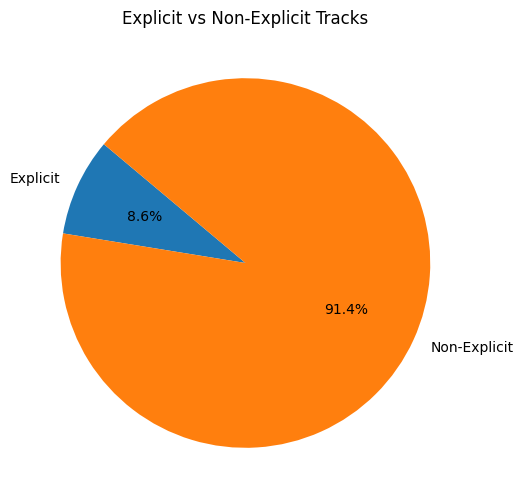

In [93]:
# plot pie chart 
labels = ['Explicit', 'Non-Explicit']
sizes = [true_percentage, false_percentage]
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Explicit vs Non-Explicit Tracks')
plt.show()

### Feature Documentation: `explicit`

#### 1️⃣ Feature Classification (Locked)

The `explicit` feature is a **content policy / labeling attribute**, not an engagement or emotional metric.

##### What it answers:
- Whether a track contains adult language, coarse expressions, or mature themes
- Whether the content may be age-restricted or sensitive

##### What it does NOT answer:
- How engaging the track is
- How the track makes users feel emotionally
- How long or how often users listen to the track

##### Implications:
- ❌ Not a KPI
- ❌ Not a direct retention or churn driver
- ✅ A contextual and policy-relevant attribute

#### 2️⃣ Distribution Sanity Check

##### Observed distribution:
- **Non-explicit:** ~91.4%
- **Explicit:** ~8.6%
- Binary variable (True / False)
- No missing values

##### Interpretation:
Explicit content represents a minority segment of the catalog. The majority of Spotify's content — and by extension, most engagement — occurs within non-explicit tracks.

##### Key insight:
- Explicit ≠ dominant listening mode
- High engagement does not require explicit content

This confirms that `explicit` should not be treated as a core performance signal.

### 3️⃣ Relevance to Retention & Churn

**Question:** Does explicit content directly affect user retention or churn?

**Correct answer:** Not directly, but contextually — and only through segmentation and policy.

This distinction is critical. Any attempt to treat `explicit` as a causal driver of retention would be analytically incorrect.

### 4️⃣ Legitimate, Analytics-Safe Uses of `explicit`

##### ✅ 4.1 Segmented Engagement Analysis

After joining with user behavior data, `explicit` can support descriptive questions such as:
- Do younger users skip explicit content more often?
- Are explicit tracks more frequently filtered or restricted?
- Does engagement with explicit content vary by demographic or region?

These analyses are **descriptive, not causal**.

##### ✅ 4.2 Policy-Aligned Product Context

**Incorrect framing (to avoid):**
> "Not recommending explicit content will increase retention." ⚠️ This is speculative and causal.

**Correct framing (analytics-safe):**
> Explicit labeling enables age-appropriate filtering, which supports safer and more personalized user experiences.

This aligns with platform policy without overclaiming impact.

##### ✅ 4.3 Engagement Contextualization

Explicit content may correlate with:
- Certain genres
- Higher speechiness
- Increased lyrical density

These relationships help explain why some tracks behave differently in engagement metrics, without asserting causality.

### 5️⃣ What Must NOT Be Done with `explicit`

To maintain analytical integrity:

- ❌ Do NOT treat `explicit` as a retention optimization lever
- ❌ Do NOT infer moral, quality, or value judgments
- ❌ Do NOT recommend removing or suppressing explicit content to "improve engagement"

These are product and policy decisions, not analytics conclusions.

### 6️⃣ Handling Strategy

##### Track level:
- Retain as boolean (`True / False`)
- No transformation applied

##### Analytical use:
- User and content segmentation
- Policy-aligned insights
- Contextual explanation

##### Dashboard use:
- Filters
- Proportional breakdowns
- Demographic splits (post user-behavior join)

#### 7️⃣ Final Decision — `explicit` (LOCKED)

| Aspect | Decision |
|--------|----------|
| Keep feature | ✅ Yes |
| KPI | ❌ No |
| Retention driver | ❌ No |
| Segmentation attribute | ✅ Yes |
| Policy relevance | ✅ Yes |

### acousticness

In [94]:
df['acousticness'].nunique()

5061

In [95]:
df['acousticness'].describe()

count    114000.000000
mean          0.314910
std           0.332523
min           0.000000
25%           0.016900
50%           0.169000
75%           0.598000
max           0.996000
Name: acousticness, dtype: float64

In [96]:
df['acousticness'].duplicated().sum()

np.int64(108939)

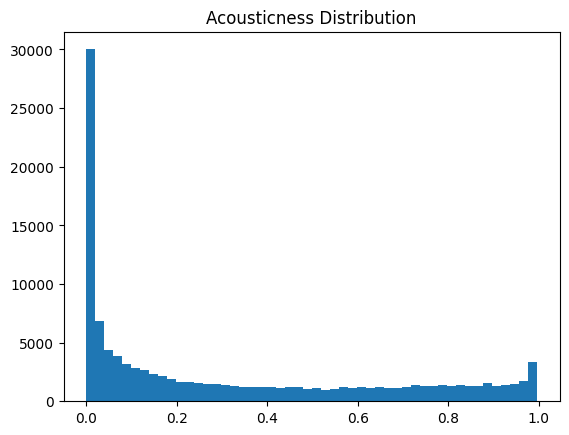

In [97]:
plt.hist(df['acousticness'], bins=50)
plt.title('Acousticness Distribution')
plt.show()

### Feature Documentation: `acousticness`

#### 1️⃣ Feature Classification

`acousticness` is a **production style / content texture attribute**.

It represents the likelihood that a track is produced using acoustic (non-electronic) instrumentation.

- ❌ Not a technical signal feature
- ❌ Not an emotional perception feature
- ✅ A contextual bridge feature that helps explain emotional characteristics

#### 2️⃣ Data Quality & Distribution Overview

- **Total records:** 114,000
- **Missing values:** 0
- **Unique values:** 5,061
- **Value range:** 0.0 – 0.996

##### Summary statistics:
- **Mean:** 0.315
- **Median:** 0.169
- **75th percentile:** 0.598

##### Distribution characteristics:
- Strong right-skew
- Majority of tracks have low acousticness
- Smaller subset of tracks exhibit high acoustic probability

This reflects the platform's catalog composition, where electronically produced music dominates.

#### 3️⃣ Analytical Interpretation

`acousticness` is a probabilistic measure, not a binary indicator. Higher values indicate a greater likelihood of acoustic production rather than absolute acoustic purity.

### The distribution indicates:
- Most tracks are electronically or digitally produced
- A meaningful minority of tracks emphasize acoustic instrumentation

#### 4️⃣ Relationship to Emotional Features

`acousticness` helps contextualize emotional perception:

##### Higher acousticness often corresponds to:
- Lower loudness
- Lower energy
- More intimate or subdued emotional tone

It does not define emotion directly but explains why emotional features manifest differently across tracks.

#### 5️⃣ Relevance to Engagement & Retention Analysis

- ❌ Not a direct driver of retention or churn
- ✅ Useful for content-style segmentation
- ✅ Supports descriptive insights when combined with user behavior data

##### Example use:
- Understanding listening preferences for acoustic vs electronic content
- Explaining engagement differences across production styles

All interpretations remain **descriptive, not causal**.

#### 6️⃣ Handling Strategy

##### Track level
- Retained as continuous numeric feature
- No transformation applied

##### Analytical use
- Bridge between technical and emotional features
- Content and production-style segmentation
- Interpretive context for engagement analysis

##### Dashboard use
- Filters and grouping (acoustic vs electronic spectrum)
- Cross-analysis with emotional features and genres

#### 7️⃣ Final Decision — `acousticness`

| Aspect | Decision |
|--------|----------|
| Keep feature | ✅ Yes |
| Emotional metric | ❌ No |
| Retention driver | ❌ No |
| Contextual / bridge feature | ✅ Yes |
| Dashboard suitability | ✅ Yes |

---

#### 📎 One-line takeaway

**Acousticness describes how a track is produced, enabling clearer interpretation of emotional and engagement patterns without introducing causal bias.**

### instrumentalness

In [98]:
df['instrumentalness'].nunique()

5346

In [99]:
df['instrumentalness'].describe()

count    114000.000000
mean          0.156050
std           0.309555
min           0.000000
25%           0.000000
50%           0.000042
75%           0.049000
max           1.000000
Name: instrumentalness, dtype: float64

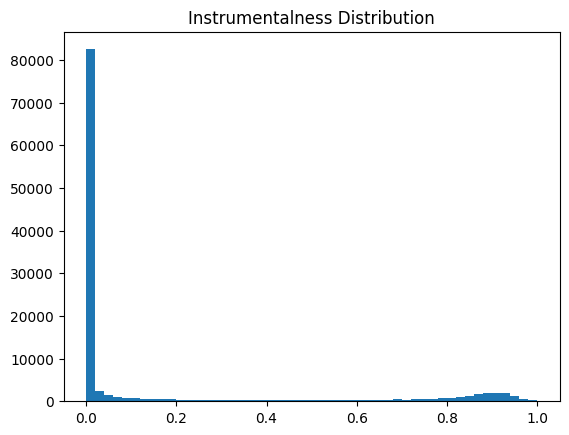

In [100]:
plt.hist(df['instrumentalness'], bins=50)
plt.title('Instrumentalness Distribution')
plt.show()

## Feature Documentation: `instrumentalness`

### 1️⃣ Feature Classification

`instrumentalness` is a **content structure attribute**.

It represents the likelihood that a track contains no vocals and is primarily instrumental.

- ❌ Not a technical signal feature
- ❌ Not an emotional perception feature
- ✅ A contextual / structural feature describing vocal presence

### 2️⃣ Data Quality & Distribution Overview

- **Total records:** 114,000
- **Missing values:** 0
- **Unique values:** 5,346
- **Value range:** 0.0 – 1.0

#### Summary statistics:
- **Mean:** 0.156
- **Median:** ~0.00004
- **75th percentile:** 0.049

#### Distribution characteristics:
- Extremely right-skewed
- Large concentration near 0.0
- Long tail toward 1.0

This indicates that the vast majority of tracks contain vocals, with a relatively small subset being strongly instrumental.

### 3️⃣ Analytical Interpretation

`instrumentalness` is a probabilistic score, not a binary label.

- **Values near 0.0** → vocals are present
- **Values near 1.0** → high likelihood of instrumental-only content

The observed distribution is expected for a mainstream music catalog, where vocal tracks dominate.

### 4️⃣ Relationship to Emotional & Engagement Context

`instrumentalness` helps explain listening context, not emotion directly.

#### Typical interpretive patterns:
- Higher instrumentalness → less speechiness
- Instrumental tracks often align with:
  - Focus-oriented listening
  - Background music
  - Ambient or classical genres

This feature explains why certain tracks may show different engagement behaviors when joined with user activity data.

### 5️⃣ Relevance to Retention & Engagement Analysis

- ❌ Not a direct driver of retention or churn
- ✅ Useful for contextual segmentation
- ✅ Helps differentiate listening modes (active vs passive)

#### Example (analytics-safe):
Instrumental tracks may support sustained listening in focus-oriented contexts without requiring lyrical engagement.

All insights remain **descriptive, not causal**.

### 6️⃣ What We Must NOT Do with `instrumentalness`

- ❌ Treat it as an emotional indicator
- ❌ Use it as a standalone engagement metric
- ❌ Over-interpret low values as low-quality content

It exists to provide structure and context, not performance judgment.

### 7️⃣ Handling Strategy

#### Track level
- Retain as continuous numeric feature
- No transformation applied

#### Analytical use
- Content structure segmentation
- Contextual explanation of engagement patterns
- Complement to speechiness and acousticness

#### Dashboard use
- Filters (instrumental vs vocal-heavy content)
- Distribution and proportion views
- Cross-analysis with genres and emotional features

### 8️⃣ Final Decision — `instrumentalness`

| Aspect | Decision |
|--------|----------|
| Keep feature | ✅ Yes |
| Emotional metric | ❌ No |
| Retention driver | ❌ No |
| Contextual / structural feature | ✅ Yes |
| Dashboard suitability | ✅ Yes |

---

### 📎 One-line takeaway

**Instrumentalness describes the presence of vocals in a track, enabling clearer interpretation of listening context and engagement patterns without introducing causal assumptions.**

### 📌 Final Feature Taxonomy — Track / Audio Dataset

This table classifies each feature by type, role, and analytical usage, and explicitly states whether it is kept or dropped.

#### 🧱 1. Identifier & Structural Features

| Feature | Category | Role in Analysis | Keep / Drop | Notes |
|---------|----------|------------------|-------------|-------|
| `track_id` | Identifier | Primary join key | ✅ Keep | Used to join with user behavior & mapping tables |
| `artists` | Dimension (raw) | Reference only | ⚠️ Keep (raw) | Retained but not used directly for aggregation |
| `track_artist_map` | Dimension (normalized) | Artist-level aggregation | ✅ Keep | Created via exploded mapping |
| `album_name` | Dimension | Catalog grouping | ✅ Keep | Optional aggregation level |
| `track_name` | Descriptor | Display only | ⚠️ Optional | Not analytical |
| `track_genre` | Dimension (raw) | Reference only | ⚠️ Keep (raw) | Used to build genre map |
| `track_genre_map` | Dimension (normalized) | Genre-level aggregation | ✅ Keep | Many-to-many safe mapping |
| `Unnamed: 0` | Artifact | None | ❌ Drop | Index artifact |

#### 🎭 2. Emotional Audio Features (Perceptual Layer)

These represent how the music feels to listeners.

| Feature | Category | Role | Keep / Drop | Notes |
|---------|----------|------|-------------|-------|
| `valence` | Emotional | Mood / positivity | ✅ Keep | Balanced distribution |
| `energy` | Emotional | Intensity / arousal | ✅ Keep | Strongly grounded by loudness |
| `danceability` | Emotional | Rhythm & movement | ✅ Keep | Near-normal distribution |
| `speechiness` | Emotional | Vocal dominance | ✅ Keep | Right-skewed, interpretable |
| `liveness` | Emotional | Live performance feel | ✅ Keep | Contextual, not dominant |

#### 🎛️ 3. Technical Audio Features (Signal Construction)

These explain emotional features, not user behavior.

| Feature | Category | Role | Keep / Drop | Notes |
|---------|----------|------|-------------|-------|
| `tempo` | Technical | Rhythmic speed | ✅ Keep | Weak but intuitive correlations |
| `loudness` | Technical | Amplitude / intensity | ✅ Keep | Strong grounding for energy |
| `mode` | Technical | Tonal context | ✅ Keep | Minor vs major mood modifier |
| `key` | Technical | Musical key | ❌ Drop | No business relevance |
| `time_signature` | Technical | Meter | ❌ Drop | Low variance, no insight |

#### 🎚️ 4. Contextual / Content Attributes (Bridge Layer)

These describe what kind of content this is, not how it feels.

| Feature | Category | Role | Keep / Drop | Notes |
|---------|----------|------|-------------|-------|
| `acousticness` | Production style | Acoustic vs electronic | ✅ Keep | Emotional context bridge |
| `instrumentalness` | Content structure | Vocal vs instrumental | ✅ Keep | Explains listening context |
| `explicit` | Content policy | Age-sensitive labeling | ✅ Keep | Segmentation & ethics |
| `duration_ms` | Track metadata | Track length | ❌ Drop | Not listening duration |

#### 📊 5. Platform-Derived Feature

| Feature | Category | Role | Keep / Drop | Notes |
|---------|----------|------|-------------|-------|
| `popularity` | Platform outcome | Benchmark / segmentation | ✅ Keep (carefully) | Never causal, never predictive |

In [103]:
# main cleaned track-level dataset
df.to_csv("C:/Users/adith/spotify_analytics/data/cleaned/audio_features_cleaned.csv", index=False)

# mapping tables
track_artist_map.to_csv("C:/Users/adith/spotify_analytics/data/cleaned/track_artist_map.csv", index=False)
track_genre_map.to_csv("C:/Users/adith/spotify_analytics/data/cleaned/track_genre_map.csv", index=False)
